In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
%matplotlib inline

In [2]:
import sys
sys.path.append('/home/courtney/voxelmorph/src')
import os
import nibabel as nib
from neuron.plot import slices
import numpy as np
import scipy.io as sio
sys.path.append('../ext/medipy-lib')
from medipy.metrics import dice
import datagenerators
from neuron.plot import slices
from pynd.segutils import seg_overlay, seg_overlap
import matplotlib.pyplot as plt
import tensorflow as tf
from restrict import restrict_GPU_tf, restrict_GPU_keras
from keras.backend.tensorflow_backend import set_session
from keras.layers import Input
from keras.models import load_model, Model
import keras.backend as K
import scipy

from visualize import visualize_seg_contour, visualize_seg

Using TensorFlow backend.


In [3]:
atlas_n_filename = '../data/t2_atlas_n_027_S_2219.nii'
atlas_vol = nib.load(atlas_n_filename).get_data()
t1_atlas = nib.load('../data/t1_atlas.nii').get_data()

In [4]:
# d = 3
# patch_size = 3
# var=0.004
vol_size = (160, 192, 224)  
def mind(d, patch_size, var=0.004, use_ssc=False, use_gaussian_kernel=False):
    # see http://www.mpheinrich.de/pub/MEDIA_mycopy.pdf
    if use_gaussian_kernel:
        dist = tf.distributions.Normal(0., 1.)

        vals = dist.prob(tf.range(start = -(patch_size-1)/2, limit = (patch_size-1)/2 + 1, dtype = tf.float32))
        kernel = tf.einsum('i,j,k->ijk', vals, vals, vals)
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = kernel[:,:,:,tf.newaxis, tf.newaxis]
    else:
        kernel = tf.ones([patch_size, patch_size, patch_size, 1, 1])/(patch_size**3)
        
    def ssd_shift(image, direction):
        # expects a 3d image
        x,y,z = vol_size
        new_shift = np.clip(direction, 0, None)
        old_shift = -np.clip(direction, None, 0)

        # translate images
        new_image = image[new_shift[0]:x-old_shift[0], new_shift[1]:y-old_shift[1], new_shift[2]:z-old_shift[2]]
        old_image = image[old_shift[0]:x-new_shift[0], old_shift[1]:y-new_shift[1], old_shift[2]:z-new_shift[2]]
        # get squared difference
        diff = tf.square(new_image - old_image)

        # pad the diff
        padding = np.transpose([old_shift, new_shift])
        diff = tf.pad(diff, padding)

        # apply convolution
        conv = tf.nn.conv3d(diff[tf.newaxis,:,:,:,tf.newaxis], kernel, [1]*5, 'SAME')
        return tf.exp(-conv/var)

    def mind_loss(y_true, y_pred):
        ndims = 3
        y_true = tf.squeeze(y_true)
        y_pred = tf.squeeze(y_pred)
        loss_tensor = 0
        for i in range(ndims):
            direction = [0]*3
            direction[i] = d

            loss_tensor += tf.reduce_mean(tf.abs(ssd_shift(y_true, direction) - ssd_shift(y_pred, direction)))

            direction = [0]*3
            direction[i] = -d
            loss_tensor += tf.reduce_mean(tf.abs(ssd_shift(y_true, direction) - ssd_shift(y_pred, direction)))

        return loss_tensor/(ndims*2)

    def ssc_loss(y_true, y_pred):
        ndims = 3
        y_true = tf.squeeze(y_true)
        y_pred = tf.squeeze(y_pred)
        loss_tensor = 0
        directions = []
        for i in range(ndims):
            direction = [0]*3
            direction[i] = d
            directions.append(direction)

            direction = [0]*3
            direction[i] = -d
            directions.append(direction)

        for i in range(len(directions)):
            for j in range(i, len(directions)):
                d1 = directions[i]
                d2 = directions[j]

                loss_tensor += tf.reduce_mean(tf.abs(ssd_shift(y_true, d1) - ssd_shift(y_pred, d2)))

        return loss_tensor/(len(directions)*(len(directions)-1)/2)

    if use_ssc:
        return ssc_loss
    else:
        return mind_loss



In [5]:
d = 2
patch_size = 3

gpu_id = 1
gpu = '/gpu:' + str(gpu_id)
#     print(gpu)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

restrict_GPU_tf(str(gpu_id))
restrict_GPU_keras(str(gpu_id))

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
config.allow_soft_placement = True
set_session(tf.Session(config=config))
sess = tf.Session(config=config)

Using GPU:1 with 0% of the memory
Using GPU:1 with 0% of the memory


In [4]:
original = nib.load("../data/t1_atlas.nii").get_data()
original_seg = nib.load("../data/t1_atlas_seg.nii").get_data()
atlas = nib.load("../data/t2_atlas_n_027_S_2219.nii").get_data()
atlas_seg = nib.load("../data/t2_atlas_seg_027_S_2219.nii").get_data()
ants_warped = nib.load("../scratch/test_ants_t1tot2.nii.gz").get_data()
nifty_warped = nib.load("../scratch/test_niftyreg_t1tot2.nii").get_data()
nifty_seg = nib.load('../scratch/test_niftyreg_t1tot2_seg.nii').get_data()
ants_seg = nib.load('../scratch/test_ants_t1tot2_seg.nii').get_data()
vm_warped = nib.load("../scratch/test_mi.nii").get_data()
vm_seg = nib.load('../scratch/test_mi_seg.nii').get_data()
mind_warped = nib.load("../scratch/test_mind.nii").get_data()
mind_seg = nib.load('../scratch/test_mind_seg.nii').get_data()
mi_supervised_warped = nib.load("../scratch/test_mi_supervised.nii").get_data()
mi_supervised_seg = nib.load('../scratch/test_mi_supervised_seg.nii').get_data()

In [5]:
good_labels = sio.loadmat('../data/labels.mat')['labels'][0]
idx_map = {}
for i in range(len(good_labels)):
    idx_map[good_labels[i]] = i

regions = ['Brain-Stem', 'Thalamus', 'Cerebellum-Cortex', 'Cerebral-W.Matter', 'Cerebellum-W.Matter', 'Putamen', 'VentralDC', 'Palladium', 'Caudate', 'Lateral-Ventricle', 'Hippocampus', '3rd-Ventricle', '4th-Ventricle', 'Amygdala', 'Cerebral-Cortex', 'CSF', 'choroid-plexus']
reg_to_num_list = {'Brain-Stem': [16],
                   'Thalamus': [10, 46],
                   'Cerebellum-Cortex': [8, 47],
                   'Cerebral-W.Matter': [2, 41],
                   'Cerebellum-W.Matter': [7, 46],
                   'Putamen': [12, 51],
                   'VentralDC': [28, 60],
                   'Palladium': [13, 52],
                   'Caudate': [11, 50],
                   'Lateral-Ventricle': [4, 43],
                   'Hippocampus': [17, 53],
                   '3rd-Ventricle': [14],
                   '4th-Ventricle': [15],
                   'Amygdala': [18, 54],
                   'Cerebral-Cortex': [3, 42],
                   'CSF': [24],
                   'choroid-plexus': [31, 63]}


In [7]:
atlas = nib.load("../data/t2_atlas_n_027_S_2219.nii").get_data()
atlas_seg = nib.load("../data/t2_atlas_seg_027_S_2219.nii").get_data()

In [9]:
t2_original = nib.load('../t2_027_S_2219_2017.nii').get_data()

In [6]:
t1_fake_atlas = nib.load('../scratch/t1_atlas_027_S_2219.nii').get_data()

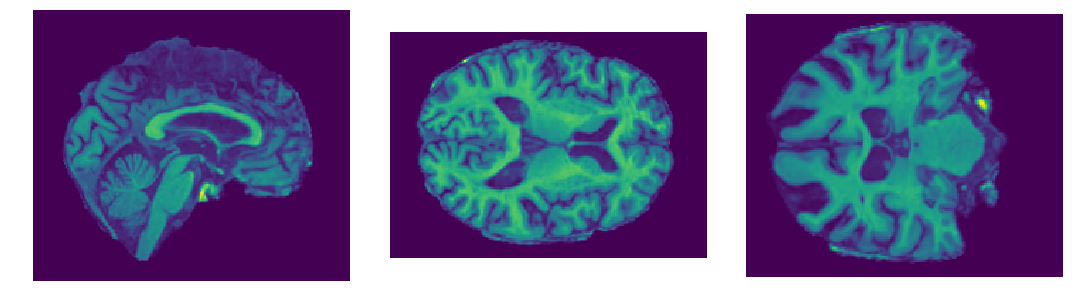

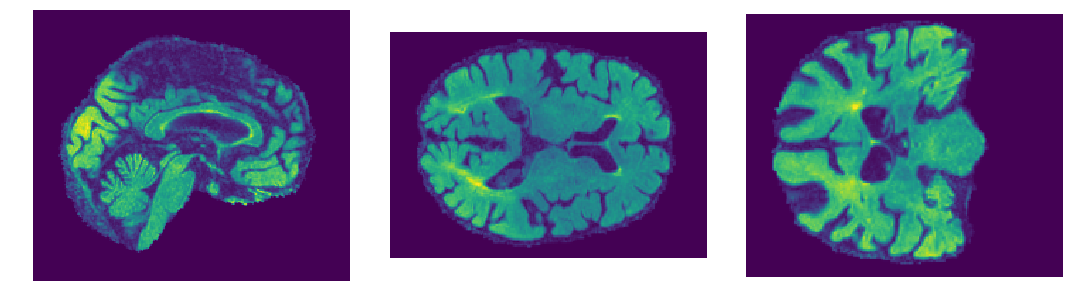

(<matplotlib.figure.Figure at 0x7fc0163cf7b8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7fc016350898>,
       dtype=object))

In [10]:
slices([t1_fake_atlas[80,:,:], t1_fake_atlas[:,90,:], t1_fake_atlas[:,:,100]])
slices([atlas[80,:,:], atlas[:,90,:], atlas[:,:,100]])

In [10]:
t1_warped = nib.load('../scratch/t1_atlas_027_S_2219.nii').get_data()

In [11]:
def make_checkerboard(m, n, s=30):
    t1 = np.concatenate([np.ones((s,s)), np.zeros((s,s))])
    t2 = np.concatenate([np.zeros((s,s)), np.ones((s,s))])
    t = np.concatenate([t1, t2], axis=1)
    cb = np.tile(t, (m//(2*s), n//(2*s)))
    x, y = cb.shape
    cb = np.pad(cb, [(0,m-x), (0,n-y)], 'constant')
    return cb

In [12]:
print(make_checkerboard(7, 7, 3))

[[1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0.]
 [1. 1. 1. 0. 0. 0. 0.]
 [0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]


In [13]:
def interleave(img1, img2):
    cb = make_checkerboard(*img1.shape)
    img = np.zeros(cb.shape)
    img[cb==0] = img1[cb==0]
    img[cb==1] = img2[cb==1]
    return img

(160, 192, 224)

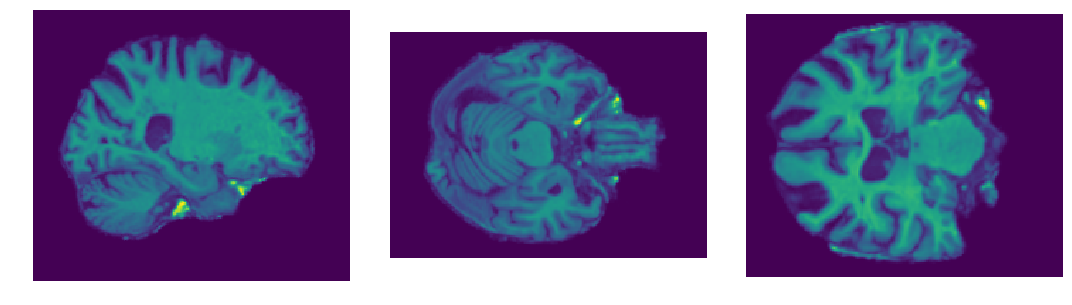

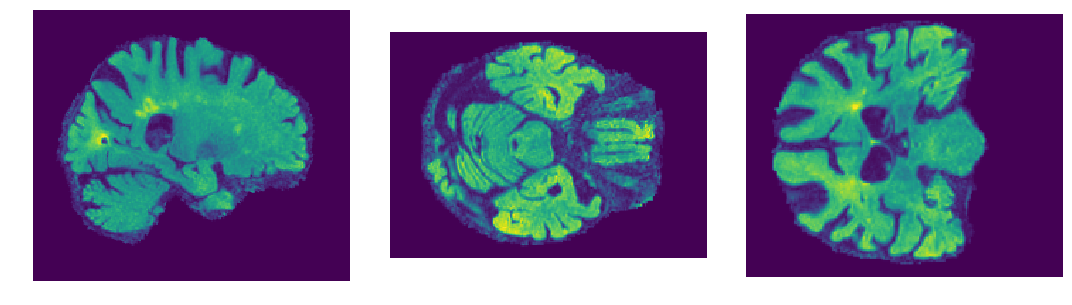

(<matplotlib.figure.Figure at 0x7f1844768160>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f18446b7ef0>,
       dtype=object))

In [96]:
slices([t1_warped[55,:,:], t1_warped[:,120,:], t1_warped[:,:,100]])
slices([atlas[55,:,:], atlas[:,120,:], atlas[:,:,100]])

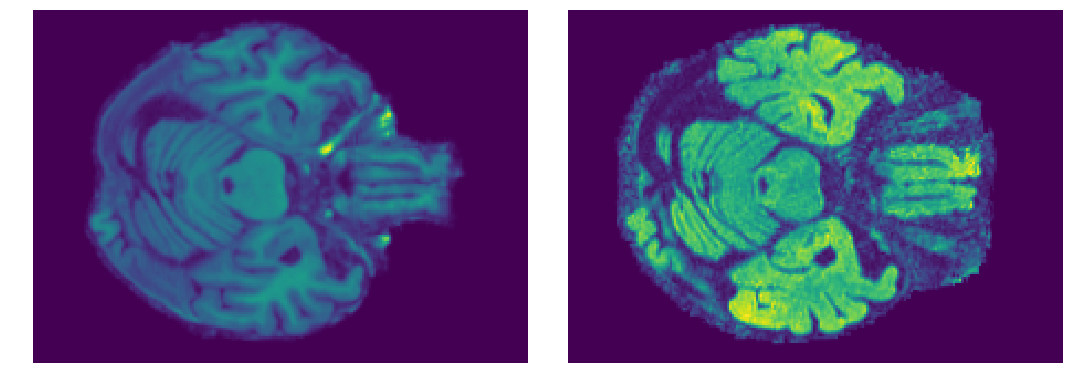

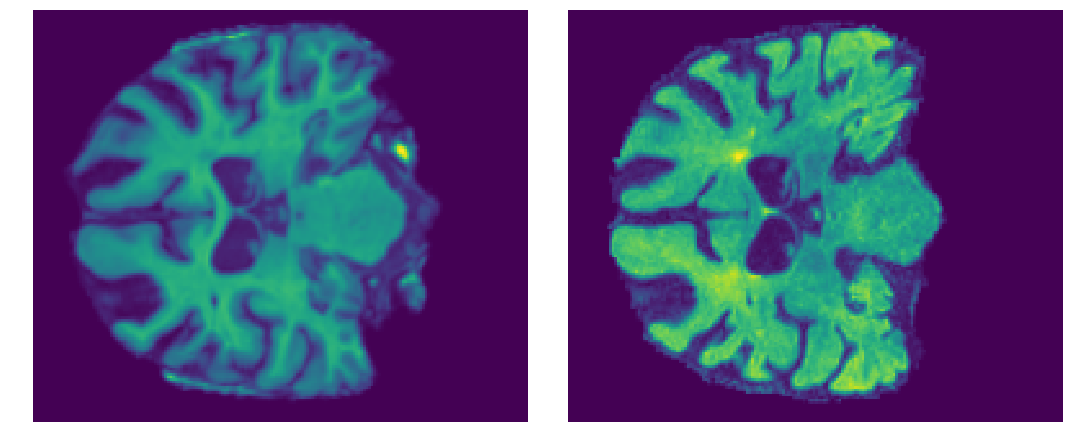

(<matplotlib.figure.Figure at 0x7f1834746ac8>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f185c1097f0>,
       dtype=object))

In [104]:
slices([t1_warped[:,120,:], atlas[:,120,:]])
slices([t1_warped[:,:,100], atlas[:,:,100]])

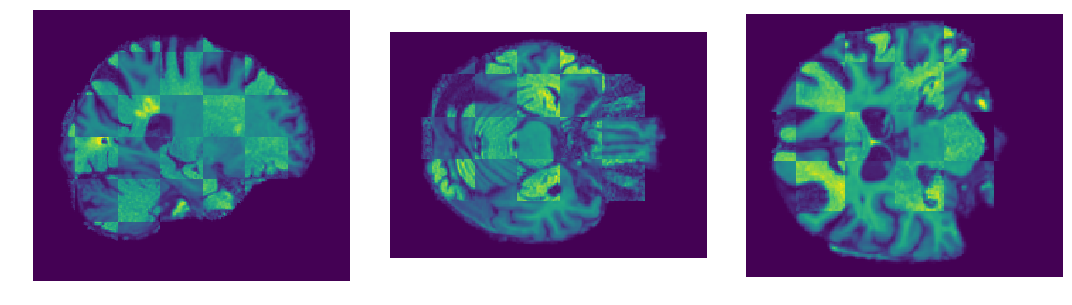

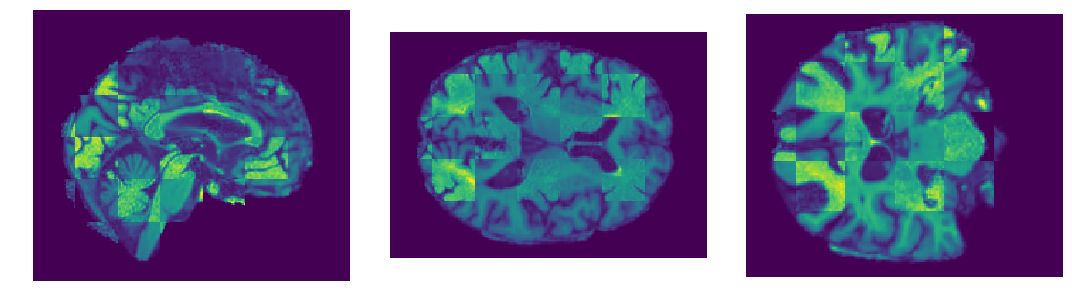

(<matplotlib.figure.Figure at 0x7f18900844e0>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f192c5ad160>,
       dtype=object))

In [101]:
slices([interleave(t1_warped[55,:,:], atlas[55,:,:]), interleave(t1_warped[:,120,:], atlas[:,120,:]), interleave(t1_warped[:,:,100], atlas[:,:,100])])
slices([interleave(t1_warped[80,:,:], atlas[80,:,:]), interleave(t1_warped[:,90,:], atlas[:,90,:]), interleave(t1_warped[:,:,100], atlas[:,:,100])])

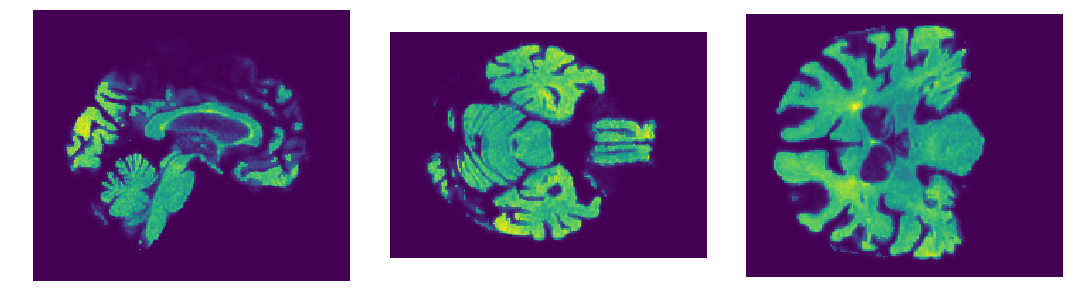

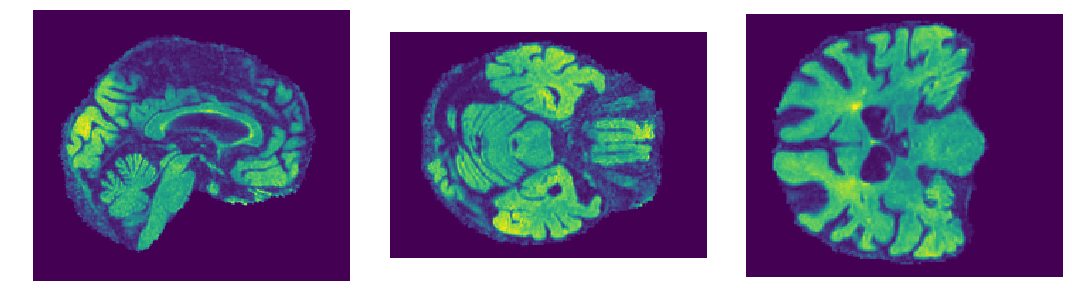

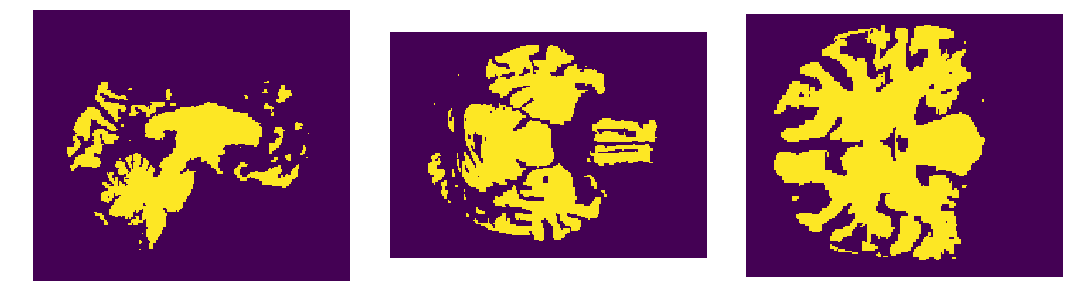

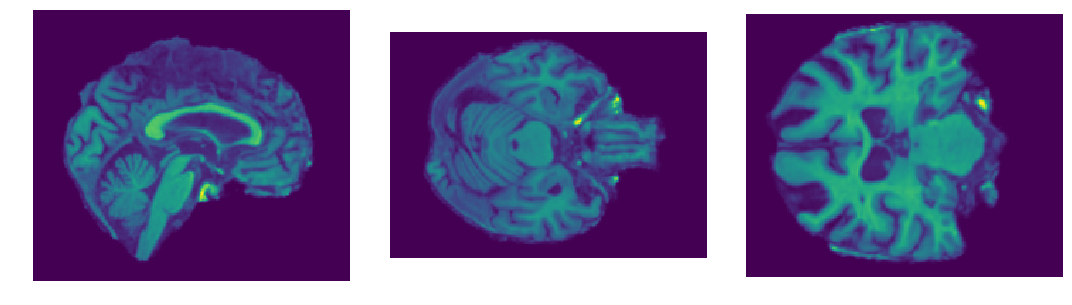

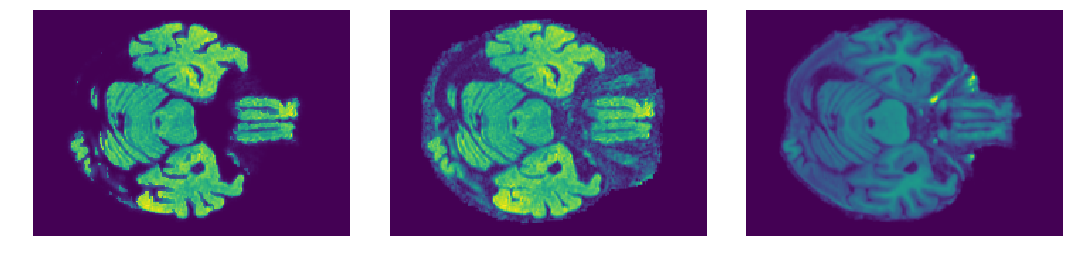

In [37]:
# atlas_stripped = np.copy(atlas)
blurred_seg = np.ones(atlas_seg.shape)
blurred_seg[atlas_seg==0] = 0
blurred_seg = scipy.ndimage.gaussian_filter(blurred_seg, 2)
mask = np.maximum(atlas_seg!=0, blurred_seg)
# thresh = 0.1
atlas_stripped = atlas*mask
test = np.ones(atlas_seg.shape)
test[atlas_seg==0] = 0
slices([atlas_stripped[80,:,:], atlas_stripped[:,120,:], atlas_stripped[:,:,100]])
slices([atlas[80,:,:], atlas[:,120,:], atlas[:,:,100]])
slices([test[80,:,:], test[:,120,:], test[:,:,100]])
slices([t1_warped[80,:,:], t1_warped[:,120,:], t1_warped[:,:,100]])
slices([atlas_stripped[:,120,:], atlas[:,120,:], t1_warped[:,120,:]])

nii = nib.Nifti1Image(atlas_stripped, np.eye(4)); 
nib.save(nii, '../data/t2_atlas_stripped2_027_S_2219');

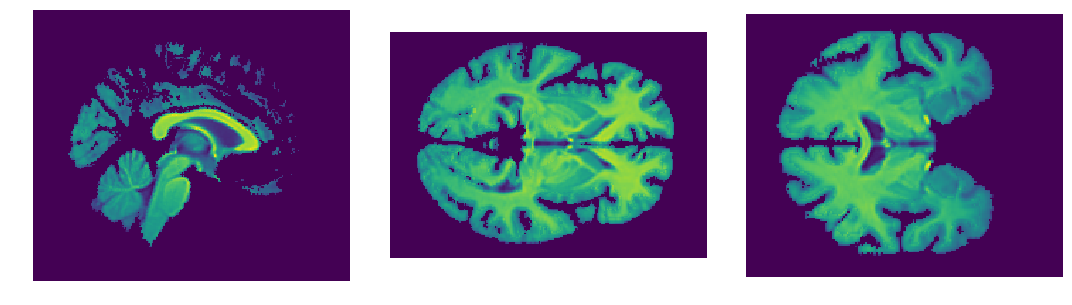

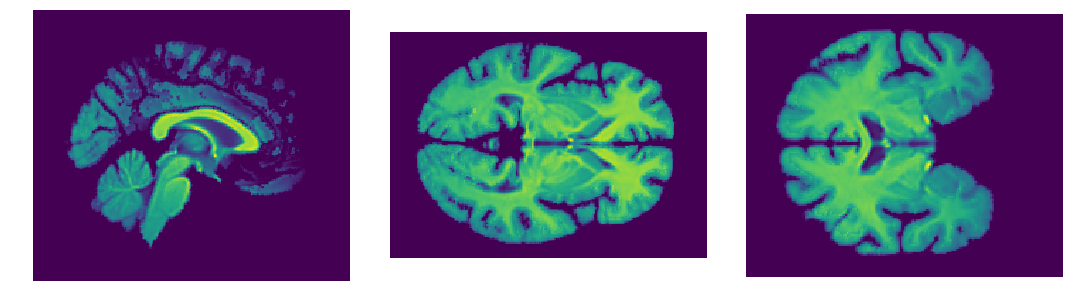

(<matplotlib.figure.Figure at 0x7f192a8dc780>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f192a789588>,
       dtype=object))

In [119]:
t1_atlas = nib.load("../data/t1_atlas.nii").get_data()
t1_atlas_seg = nib.load("../data/t1_atlas_seg.nii").get_data()
atlas_stripped = np.copy(t1_atlas)
atlas_stripped[t1_atlas_seg==0] = 0
test = np.ones(t1_atlas_seg.shape)
test[atlas_seg==0] = 0
slices([atlas_stripped[80,:,:], atlas_stripped[:,100,:], atlas_stripped[:,:,120]])
slices([t1_atlas[80,:,:], t1_atlas[:,100,:], t1_atlas[:,:,120]])

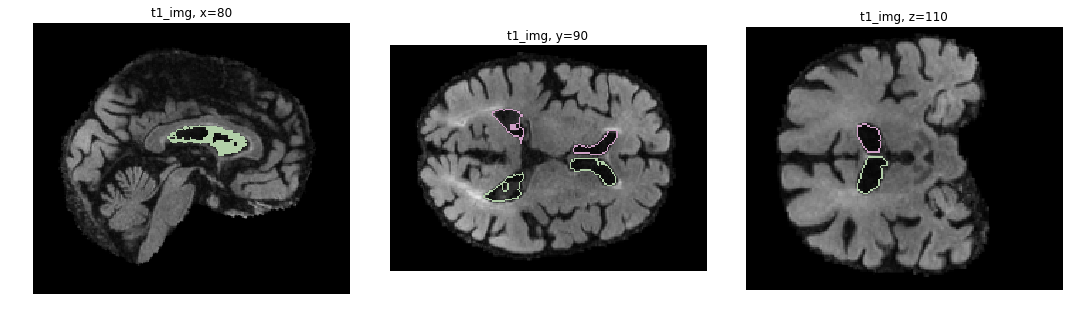

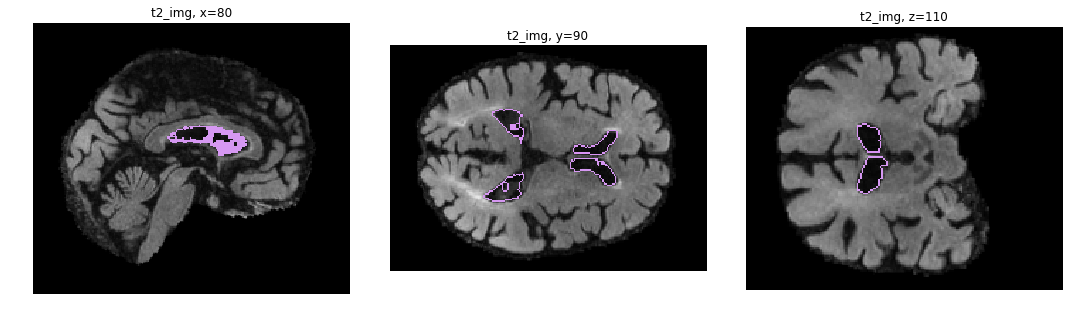

In [32]:
visualize_seg_contour(t1_warped, atlas_seg, title='t1_img', region_numbers=reg_to_num_list['Lateral-Ventricle'])
visualize_seg_contour(atlas, atlas_seg, title='t2_img', region_numbers=reg_to_num_list['Lateral-Ventricle'])


In [105]:
visualize_seg_contour(t1_original, atlas_seg, title='t1_img', region_numbers=reg_to_num_list['Hippocampus'], slice_idx=[55, 120, 100])
visualize_seg_contour(t1_test, atlas_seg, title='t1_img', region_numbers=reg_to_num_list['Hippocampus'], slice_idx=[55, 120, 100])
visualize_seg_contour(t1_original, t1_original_seg, title='t1_img', region_numbers=reg_to_num_list['Hippocampus'], slice_idx=[55, 120, 100])


NameError: name 't1_original' is not defined

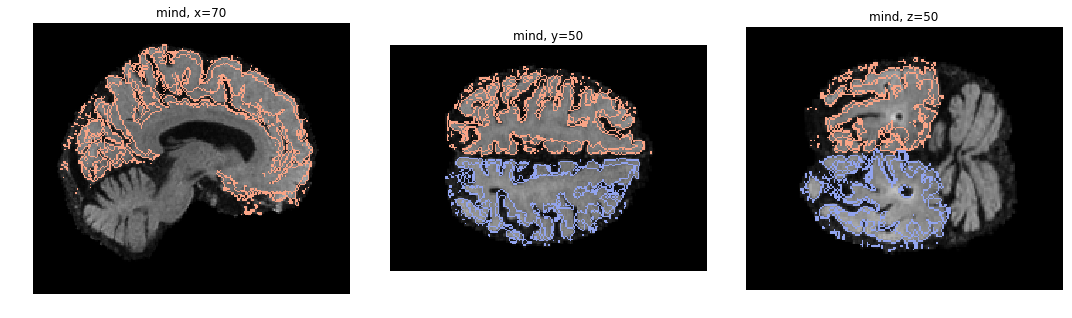

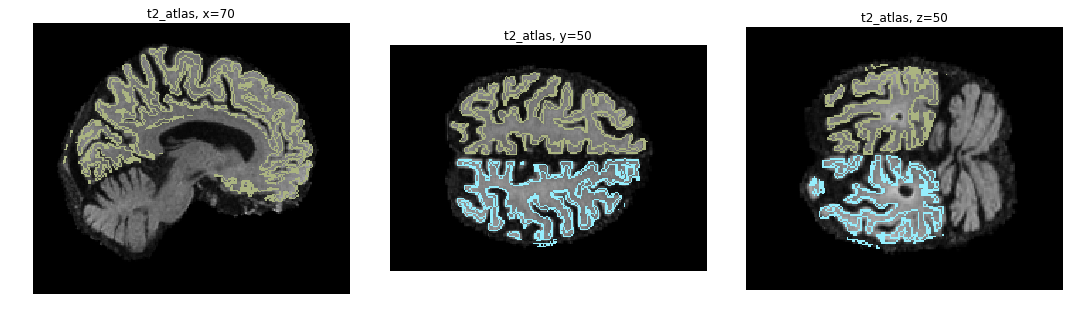

NameError: name 'X_vol' is not defined

In [108]:
# visualize_seg_contour(atlas, mi_seg, title='mi', region_numbers=reg_to_num_list['Cerebral-Cortex'], slice_idx=[70, 50, 50])
visualize_seg_contour(atlas, mind_seg, title='mind', region_numbers=reg_to_num_list['Cerebral-Cortex'], slice_idx=[70, 50, 50])
visualize_seg_contour(atlas, atlas_seg, title='t2_atlas', region_numbers=reg_to_num_list['Cerebral-Cortex'], slice_idx=[70, 50, 50])
visualize_seg_contour(X_vol[0,:,:,:,0], X_seg[0,:,:,:,0], title='original', region_numbers=reg_to_num_list['Cerebral-Cortex'], slice_idx=[70, 50, 50])
visualize_seg_contour(t1_atlas, vm_t1_seg, title='vm_t1', region_numbers=reg_to_num_list['Cerebral-Cortex'], slice_idx=[70, 50, 50])

slices([atlas[70,:,:], atlas[:,50,:], atlas[:,:,50]], cmaps=['viridis', 'viridis', 'viridis'], do_colorbars=True)

In [106]:
visualize_seg_contour(atlas, mi_seg, title='mi', region_numbers=reg_to_num_list['Hippocampus'], slice_idx=[55, 120, 100])
visualize_seg_contour(atlas, mind_seg, title='mind', region_numbers=reg_to_num_list['Hippocampus'], slice_idx=[55, 120, 100])
visualize_seg_contour(atlas, atlas_seg, title='t2_atlas', region_numbers=reg_to_num_list['Hippocampus'], slice_idx=[55, 120, 100])
visualize_seg_contour(X_vol[0,:,:,:,0], X_seg[0,:,:,:,0], title='original', region_numbers=reg_to_num_list['Hippocampus'], slice_idx=[55, 120, 100])
visualize_seg_contour(t1_atlas, vm_t1_seg, title='vm_t1', region_numbers=reg_to_num_list['Hippocampus'], slice_idx=[55, 120, 100])

slices([atlas[55,:,:], atlas[:,120,:], atlas[:,:,100]], cmaps=['viridis', 'viridis', 'viridis'], do_colorbars=True)

NameError: name 'mi_seg' is not defined

nifty dice 0.627055056918378
ants dice 0.64382466320125
vm dice 0.7083782131499812
mind dice 0.70300500204986


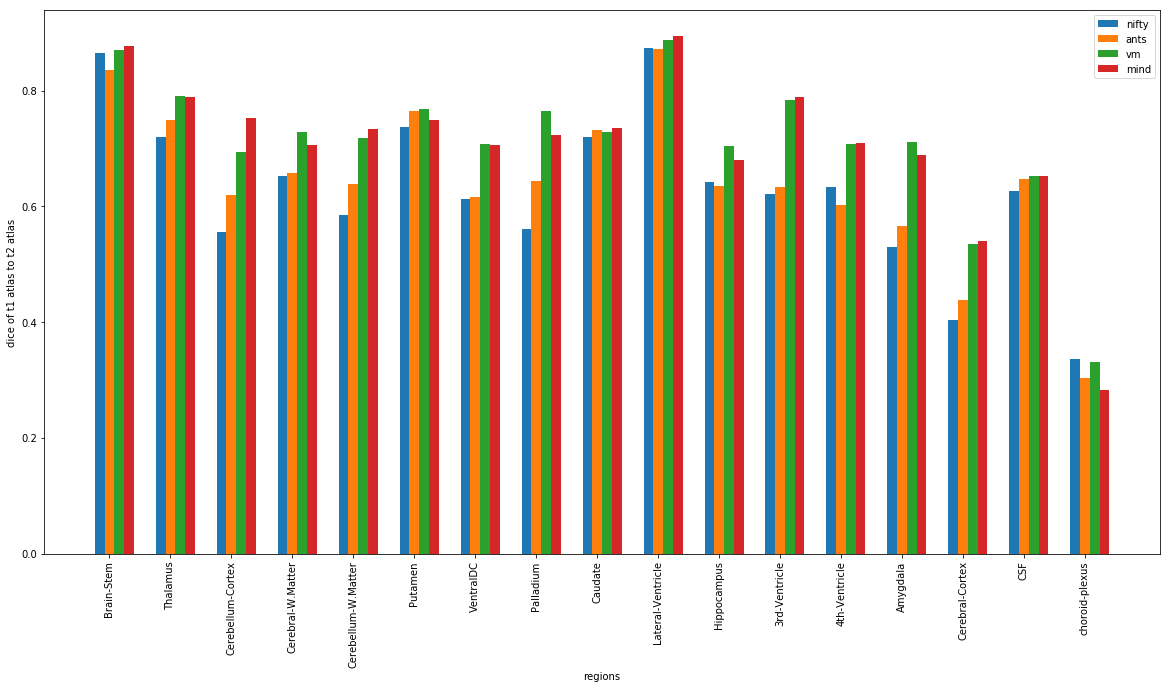

In [27]:
plt.figure(figsize=(20,10))
nifty_dice, _ = dice(new_atlas_seg, nifty_seg, labels=good_labels, nargout=2)
ants_dice, _ = dice(new_atlas_seg, ants_seg, labels=good_labels, nargout=2)
vm_dice, _ = dice(new_atlas_seg, vm_seg, labels=good_labels, nargout=2)
mind_dice, _ = dice(new_atlas_seg, mind_seg, labels=good_labels, nargout=2)

print('nifty dice', np.mean(nifty_dice))
print('ants dice', np.mean(ants_dice))
print('vm dice', np.mean(vm_dice))
print('mind dice', np.mean(mind_dice))

inds = np.arange(len(regions))
nifty_dice_ordered = []
ants_dice_ordered = []
vm_dice_ordered = []
mind_dice_ordered = []

for region in regions:
    nifty_sum = 0
    ants_sum = 0
    vm_sum = 0
    mind_sum = 0
    for num in reg_to_num_list[region]:
        nifty_sum += nifty_dice[idx_map[num]]
        ants_sum += ants_dice[idx_map[num]]
        vm_sum += vm_dice[idx_map[num]]
        mind_sum += mind_dice[idx_map[num]]

    nifty_dice_ordered.append(nifty_sum/len(reg_to_num_list[region]))
    ants_dice_ordered.append(ants_sum/len(reg_to_num_list[region]))
    vm_dice_ordered.append(vm_sum/len(reg_to_num_list[region]))
    mind_dice_ordered.append(mind_sum/len(reg_to_num_list[region]))

plt.bar(inds, nifty_dice_ordered, 0.16, label='nifty')
plt.bar(inds+0.16, ants_dice_ordered, 0.16, label='ants')
plt.bar(inds+0.32, vm_dice_ordered, 0.16, label='vm')
plt.bar(inds+0.48, mind_dice_ordered, 0.16, label='mind')

plt.legend()
plt.ylabel('dice of t1 atlas to t2 atlas')
plt.xlabel('regions')
plt.xticks(inds+0.16, regions, rotation='vertical')
plt.show()

nifty dice 0.6242017828838189
ants dice 0.6402834106439894
vm dice 0.7032281118098778
mind dice 0.6982424279736181


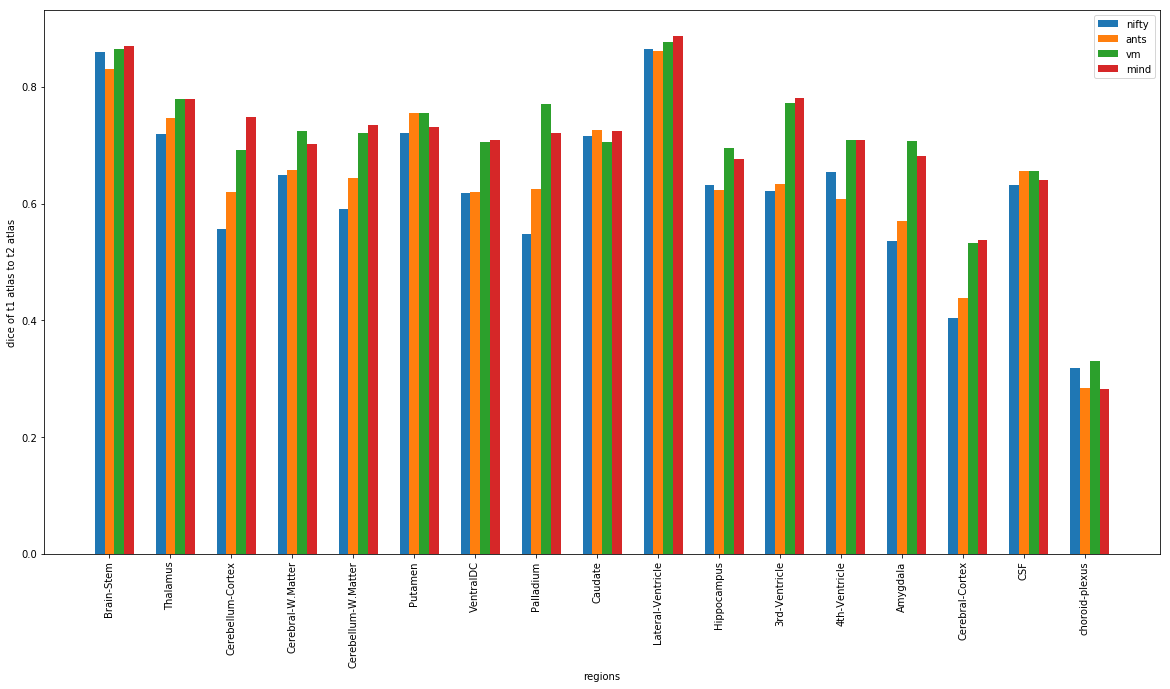

In [14]:
plt.figure(figsize=(20,10))
nifty_dice, _ = dice(atlas_seg, nifty_seg, labels=good_labels, nargout=2)
ants_dice, _ = dice(atlas_seg, ants_seg, labels=good_labels, nargout=2)
vm_dice, _ = dice(atlas_seg, vm_seg, labels=good_labels, nargout=2)
mind_dice, _ = dice(atlas_seg, mind_seg, labels=good_labels, nargout=2)

print('nifty dice', np.mean(nifty_dice))
print('ants dice', np.mean(ants_dice))
print('vm dice', np.mean(vm_dice))
print('mind dice', np.mean(mind_dice))

inds = np.arange(len(regions))
nifty_dice_ordered = []
ants_dice_ordered = []
vm_dice_ordered = []
mind_dice_ordered = []

for region in regions:
    nifty_sum = 0
    ants_sum = 0
    vm_sum = 0
    mind_sum = 0
    for num in reg_to_num_list[region]:
        nifty_sum += nifty_dice[idx_map[num]]
        ants_sum += ants_dice[idx_map[num]]
        vm_sum += vm_dice[idx_map[num]]
        mind_sum += mind_dice[idx_map[num]]

    nifty_dice_ordered.append(nifty_sum/len(reg_to_num_list[region]))
    ants_dice_ordered.append(ants_sum/len(reg_to_num_list[region]))
    vm_dice_ordered.append(vm_sum/len(reg_to_num_list[region]))
    mind_dice_ordered.append(mind_sum/len(reg_to_num_list[region]))

plt.bar(inds, nifty_dice_ordered, 0.16, label='nifty')
plt.bar(inds+0.16, ants_dice_ordered, 0.16, label='ants')
plt.bar(inds+0.32, vm_dice_ordered, 0.16, label='vm')
plt.bar(inds+0.48, mind_dice_ordered, 0.16, label='mind')

plt.legend()
plt.ylabel('dice of t1 atlas to t2 atlas')
plt.xlabel('regions')
plt.xticks(inds+0.16, regions, rotation='vertical')
plt.show()